MOVIE RECCOMENDATION SYSTEM WITH CONTENT BASED FILTERING

In [25]:
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))



In [26]:
movies_df = pd.read_csv('movies.csv')
credits_df = pd.read_csv('credits.csv')


In [27]:
movies = movies_df.merge(credits_df, on='title')


In [28]:
C = movies['vote_average'].mean()
C

6.092514036182159

In [29]:
# Drop rows with nulls in important fields
movies.dropna(subset=['overview', 'genres', 'keywords', 'cast', 'crew'], inplace=True)

# Reset index after dropping rows
movies.reset_index(drop=True, inplace=True)


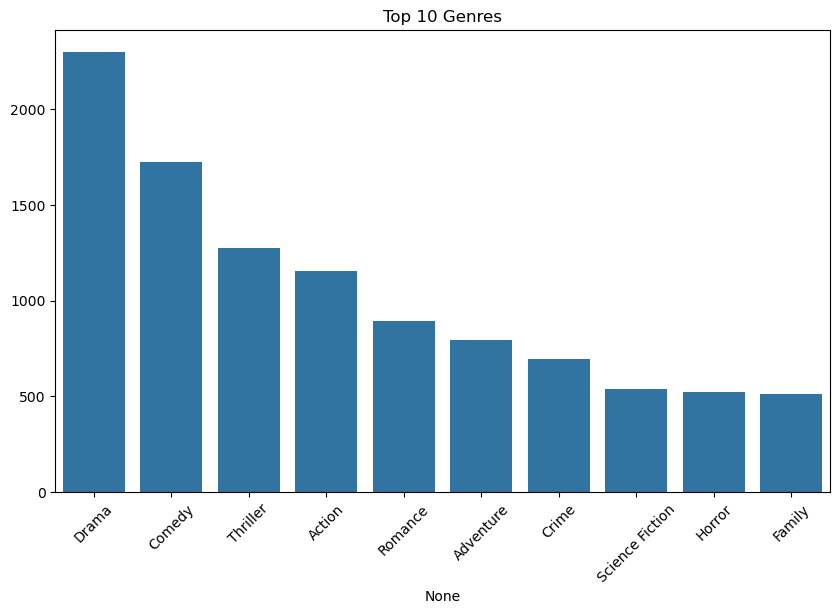

In [30]:
def extract_genres(text):
    try:
        return [g['name'] for g in ast.literal_eval(text)]
    except:
        return []

movies['genre_list'] = movies['genres'].apply(extract_genres)

all_genres = sum(movies['genre_list'], [])
plt.figure(figsize=(10, 6))
sns.barplot(x=pd.Series(all_genres).value_counts().head(10).index,
            y=pd.Series(all_genres).value_counts().head(10).values)
plt.title("Top 10 Genres")
plt.xticks(rotation=45)
plt.show()


/var/folders/xn/yw7dc6yj3mgdth1dy1l_tbpm0000gn/T/ipykernel_8970/2793015555.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='popularity', y='title', data=popular_movies, palette='viridis')


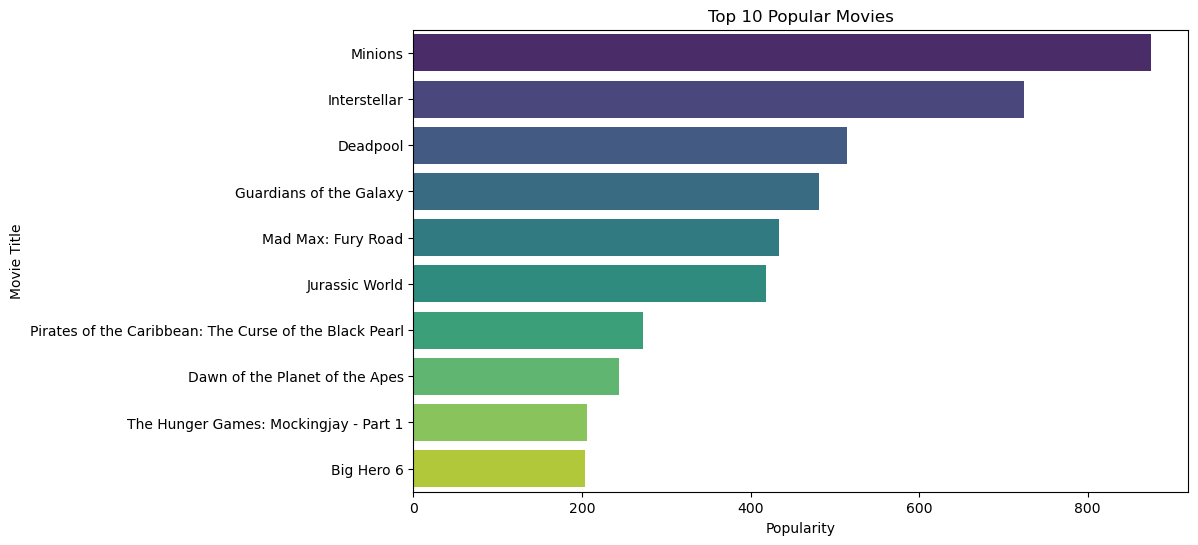

In [31]:
# Sort movies based on popularity
popular_movies = movies[['title', 'popularity']].sort_values(by='popularity', ascending=False).head(10)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='popularity', y='title', data=popular_movies, palette='viridis')
plt.title("Top 10 Popular Movies")
plt.xlabel("Popularity")
plt.ylabel("Movie Title")
plt.show()


In [32]:
def extract_keywords(text):
    try:
        return [kw['name'].replace(" ", "") for kw in ast.literal_eval(text)]
    except:
        return []

def extract_actors(text):
    try:
        return [actor['name'].replace(" ", "") for actor in ast.literal_eval(text)[:3]]
    except:
        return []

def extract_director(text):
    try:
        crew = ast.literal_eval(text)
        for member in crew:
            if member['job'] == 'Director':
                return member['name'].replace(" ", "")
    except:
        return ''


In [33]:
print(movies_df.columns)  # Check columns in the merged dataframe
print(credits_df.columns)  # Check columns in the credits dataframe


Index(['budget', 'genres', 'homepage', 'id', 'keywords', 'original_language',
       'original_title', 'overview', 'popularity', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'vote_average',
       'vote_count'],
      dtype='object')
Index(['movie_id', 'title', 'cast', 'crew'], dtype='object')


In [34]:
# Apply the extraction functions, ensuring None values are handled properly
movies['keywords_list'] = movies['keywords'].apply(lambda x: extract_keywords(x) if pd.notna(x) else [])
movies['actors'] = movies['cast'].apply(lambda x: extract_actors(x) if pd.notna(x) else [])
movies['director'] = movies['crew'].apply(lambda x: extract_director(x) if pd.notna(x) else None)

# Tokenize the 'overview' field
movies['overview_tokens'] = movies['overview'].apply(lambda x: x.split() if pd.notna(x) else [])

# Handle missing values in 'tags' column
movies['tags'] = movies['overview_tokens'] + movies['genre_list'] + \
                 movies['keywords_list'] + movies['actors'] + \
                 movies['director'].apply(lambda x: [x] if x else [])

# Replace None values with empty strings in 'tags' column before joining
movies['tags'] = movies['tags'].apply(
    lambda x: " ".join([str(item).lower() for item in x if item and str(item).lower() not in stop_words])
)


# Check the result
print(movies['tags'].head())



0    22nd century, paraplegic marine dispatched moo...
1    captain barbossa, long believed dead, come bac...
2    cryptic message bond’s past sends trail uncove...
3    following death district attorney harvey dent,...
4    john carter war-weary, former military captain...
Name: tags, dtype: object


In [35]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)  # remove non-alphabetic
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return " ".join(words)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/yashaswikathota/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/yashaswikathota/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [36]:
movies['cleaned_tags'] = movies['tags'].apply(clean_text)


In [37]:
movies['tags']

0       22nd century, paraplegic marine dispatched moo...
1       captain barbossa, long believed dead, come bac...
2       cryptic message bond’s past sends trail uncove...
3       following death district attorney harvey dent,...
4       john carter war-weary, former military captain...
                              ...                        
4801    el mariachi wants play guitar carry family tra...
4802    newlywed couple's honeymoon upended arrivals r...
4803    "signed, sealed, delivered" introduces dedicat...
4804    ambitious new york attorney sam sent shanghai ...
4805    ever since second grade first saw e.t. extrate...
Name: tags, Length: 4806, dtype: object

In [38]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(movies['cleaned_tags'])  # assuming your DataFrame is `movies`


In [39]:
tfidf

TfidfVectorizer(max_features=5000, stop_words='english')

In [49]:
from sklearn.neighbors import NearestNeighbors

# Fit KNN model once globally
knn_model = NearestNeighbors(metric='cosine', algorithm='brute')
knn_model.fit(tfidf_matrix)

def recommend_knn_cosine(movie_title, n_recommendations=5):
    # Check if movie exists
    if movie_title not in movies['title'].values:
        return "Movie not found."

    # Get index of the movie
    idx = movies[movies['title'] == movie_title].index[0]

    # Find nearest neighbors (n+1 because the movie itself will be closest)
    distances, indices = knn_model.kneighbors(tfidf_matrix[idx], n_neighbors=n_recommendations + 1)

    # Exclude the input movie (first result) and fetch recommended titles
    recommended_titles = []
    for i in range(1, len(indices[0])):
        title = movies.iloc[indices[0][i]]['title']
        dist = distances[0][i]
        recommended_titles.append(f"{title} (Distance: {dist:.3f})")

    return recommended_titles


In [51]:
recommend_knn_cosine("The Matrix")


['The Matrix Revolutions (Distance: 0.591)',
 'The Matrix Reloaded (Distance: 0.643)',
 'Hackers (Distance: 0.702)',
 'WarGames (Distance: 0.764)',
 'The Thirteenth Floor (Distance: 0.764)']

In [53]:
pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


WORDCLOUD

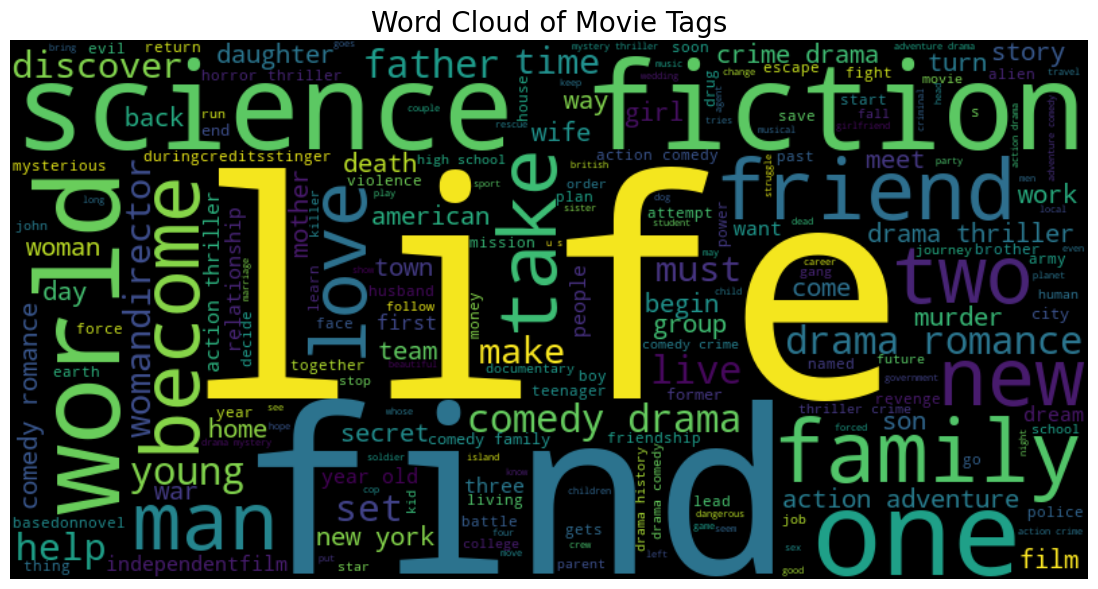

In [56]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join all tags into one big string
all_words = ' '.join(movies['tags'])

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(all_words)

# Display the word cloud
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Movie Tags", fontsize=20)
plt.show()
